In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('clean_tweets.csv')

In [3]:
df.head()

,Unnamed: 0,sentiment,text
0,0,0,awww that s a bummer you shoulda got david car...
1,1,0,is upset that he can not update his facebook b...
2,2,0,i dived many times for the ball managed to sav...
3,3,0,my whole body feels itchy and like its on fire
4,4,0,no it s not behaving at all i m mad why am i h...


In [4]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['sentiment'] = df['sentiment'].map({0:0,4:1})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
sentiment    1600000 non-null int64
text         1596714 non-null object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [6]:

df.dropna(inplace=True)

In [7]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596714 entries, 0 to 1599999
Data columns (total 2 columns):
sentiment    1596714 non-null int64
text         1596714 non-null object
dtypes: int64(1), object(1)
memory usage: 36.5+ MB


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
#need explanation well prepared
x = df['text'] #define all other columns except the target variable
y = df['sentiment'] #define the target variable

x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size = 0.02, random_state = 42)

x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, 
                                                              test_size = 0.5, random_state = 42)

In [10]:
print("Training set has {0} entries, where {1:.2f} are positive and {2:.2f} are negative".
      format(len(x_train),len(x_train[y_train==1])/len(x_train)*100, len(x_train[y_train==0])/len(x_train)*100))
print("Validation set has {0} entries, where {1:.2f} are positive and {2:.2f} are negative".
      format(len(x_validation),len(x_validation[y_validation==1])/len(x_validation)*100, 
             len(x_validation[y_validation==0])/len(x_validation)*100))
print("Testing set has {0} entries, where {1:.2f} are positive and {2:.2f} are negative".
      format(len(x_test),len(x_test[y_test==1])/len(x_test)*100, 
             len(x_test[y_test==0])/len(x_test)*100))

Training set has 1564779 entries, where 49.99 are positive and 50.01 are negative
Validation set has 15967 entries, where 49.82 are positive and 50.18 are negative
Testing set has 15968 entries, where 50.33 are positive and 49.67 are negative


In [11]:
from textblob import TextBlob

In [12]:
tbresult = []
for i in x_validation:
    tbresult.append(TextBlob(i).sentiment.polarity)

In [13]:
tbpred = []
for i in tbresult:
    if i<0:
        tbpred.append(0)
    else:
        tbpred.append(1)

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [15]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'], columns=['predicted_positive', 'predicted_negative'])
print("Accuracy score: {0:.2f} %".format(accuracy_score(y_validation, tbpred)*100))

Accuracy score: 61.41 %


In [16]:
print("Confusion Matrix")
print(confusion)


Confusion Matrix
          predicted_positive  predicted_negative
positive                7136                 818
negative                5344                2669


In [17]:
print("Classification Report")
print(classification_report(y_validation, tbpred))

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.33      0.46      8013
           1       0.57      0.90      0.70      7954

    accuracy                           0.61     15967
   macro avg       0.67      0.62      0.58     15967
weighted avg       0.67      0.61      0.58     15967



In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [19]:
null_accuracy = 0
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test==0])/len(x_test)>0.5:
        null_accuracy = len(x_test[y_test==0])/len(x_test)
    else:
        null_accuracy = 1 - len(x_test[y_test==0])/len(x_test)
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("Null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("Accuracy: {0:.2f}%".format(accuracy*100))
    if accuracy>null_accuracy:
        print("Model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy==null_accuracy:
        print("Model has the same accuracy as null accuracy")
    else:
        print("Model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("Train and test time: {0:.2f}s".format(train_test_time))
    print("-"*50)
    return accuracy, train_test_time

In [20]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000, 100001, 10000)

In [21]:
def nfeature_accuracy_checker(vectorizer = cvec, n_features = n_features, stop_words = None, 
                              ngram_range = (1,1), classifier = lr):
    result = []
    print(classifier, "\n")
    for n in n_features:
        vectorizer.set_params(stop_words = stop_words, max_features = n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])
        print("Validation result for {0} features".format(n))
        nfeature_accuracy, ttime = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n, nfeature_accuracy, ttime))
    return result

In [22]:
%%time
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_unigram = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 

Validation result for 10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 77.28%
Model is 27.10% more accurate than null accuracy
Train and test time: 136.00s
--------------------------------------------------
Validation result for 20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 77.52%
Model is 27.33% more accurate than null accuracy
Train and test time: 155.75s
--------------------------------------------------
Validation result for 30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 77.58%
Model is 27.39% more accurate than null accuracy
Train and test time: 193.54s
--------------------------------------------------
Validation result for 40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 77.60%
Model is 27.42% more accurate than null accuracy
Train and test time: 225.57s
--------------------------------------------------
Validation result for 50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 77.50%
Model is 27.32% more accurate than null accuracy
Train and test time: 211.16s
--------------------------------------------------
Validation result for 60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 77.55%
Model is 27.37% more accurate than null accuracy
Train and test time: 246.01s
--------------------------------------------------
Validation result for 70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 77.56%
Model is 27.38% more accurate than null accuracy
Train and test time: 248.18s
--------------------------------------------------
Validation result for 80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 77.57%
Model is 27.39% more accurate than null accuracy
Train and test time: 222.23s
--------------------------------------------------
Validation result for 90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 77.56%
Model is 27.38% more accurate than null accuracy
Train and test time: 236.58s
--------------------------------------------------
Validation result for 100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 77.56%
Model is 27.38% more accurate than null accuracy
Train and test time: 203.22s
--------------------------------------------------
Wall time: 34min 38s


In [23]:
term_freq_df.head()

NameError: name 'term_freq_df' is not defined

In [24]:
term_freq_df = pd.read_csv('term_freq_data.csv', index_col = 0)
term_freq_df.head()

,negative,positive,total
aa,168,97,265
aaa,97,55,152
aaaa,45,29,74
aaaaa,26,12,38
aaaaaa,16,12,28


In [25]:
%%time
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_unigram_stop = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 

Validation result for 10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.75%
Model is 29.56% more accurate than null accuracy
Train and test time: 191.90s
--------------------------------------------------
Validation result for 20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.94%
Model is 29.76% more accurate than null accuracy
Train and test time: 232.60s
--------------------------------------------------
Validation result for 30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.96%
Model is 29.78% more accurate than null accuracy
Train and test time: 351.43s
--------------------------------------------------
Validation result for 40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 80.03%
Model is 29.84% more accurate than null accuracy
Train and test time: 439.80s
--------------------------------------------------
Validation result for 50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 80.12%
Model is 29.93% more accurate than null accuracy
Train and test time: 367.01s
--------------------------------------------------
Validation result for 60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 80.16%
Model is 29.97% more accurate than null accuracy
Train and test time: 474.58s
--------------------------------------------------
Validation result for 70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 80.22%
Model is 30.04% more accurate than null accuracy
Train and test time: 428.29s
--------------------------------------------------
Validation result for 80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 80.26%
Model is 30.07% more accurate than null accuracy
Train and test time: 511.00s
--------------------------------------------------
Validation result for 90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 80.28%
Model is 30.10% more accurate than null accuracy
Train and test time: 539.75s
--------------------------------------------------
Validation result for 100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 80.28%
Model is 30.10% more accurate than null accuracy
Train and test time: 507.87s
--------------------------------------------------
Wall time: 1h 7min 24s


In [26]:
term_freq_df = pd.read_csv('term_freq_data.csv', index_col = 0)
term_freq_df.head()

,negative,positive,total
aa,168,97,265
aaa,97,55,152
aaaa,45,29,74
aaaaa,26,12,38
aaaaaa,16,12,28


In [27]:

term_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271304 entries, aa to zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
Data columns (total 3 columns):
negative    271304 non-null int64
positive    271304 non-null int64
total       271304 non-null int64
dtypes: int64(3)
memory usage: 8.3+ MB


In [28]:
term_freq_df.sort_values(by='total', ascending=False).head(10)

,negative,positive,total
to,313185,252600,565785
the,257953,266161,524114
my,190805,125981,316786
it,157491,147841,305332
and,153985,149692,303677
you,103865,198274,302139
not,196637,87771,284408
is,133533,111325,244858
in,115628,101297,216925
for,99044,117389,216433


In [29]:

from sklearn.feature_extraction import text

In [30]:
a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

In [31]:
my_stop_words = a

In [32]:
%%time
print("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS\n")
feature_result_wocw = nfeature_accuracy_checker(stop_words = my_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 

Validation result for 10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 78.63%
Model is 28.45% more accurate than null accuracy
Train and test time: 110.66s
--------------------------------------------------
Validation result for 20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.09%
Model is 28.90% more accurate than null accuracy
Train and test time: 138.87s
--------------------------------------------------
Validation result for 30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 78.98%
Model is 28.79% more accurate than null accuracy
Train and test time: 166.00s
--------------------------------------------------
Validation result for 40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.05%
Model is 28.87% more accurate than null accuracy
Train and test time: 190.40s
--------------------------------------------------
Validation result for 50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.08%
Model is 28.90% more accurate than null accuracy
Train and test time: 220.64s
--------------------------------------------------
Validation result for 60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.13%
Model is 28.94% more accurate than null accuracy
Train and test time: 217.36s
--------------------------------------------------
Validation result for 70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.19%
Model is 29.01% more accurate than null accuracy
Train and test time: 202.37s
--------------------------------------------------
Validation result for 80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.21%
Model is 29.02% more accurate than null accuracy
Train and test time: 260.00s
--------------------------------------------------
Validation result for 90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.17%
Model is 28.98% more accurate than null accuracy
Train and test time: 249.33s
--------------------------------------------------
Validation result for 100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.18%
Model is 28.99% more accurate than null accuracy
Train and test time: 242.82s
--------------------------------------------------
Wall time: 33min 18s


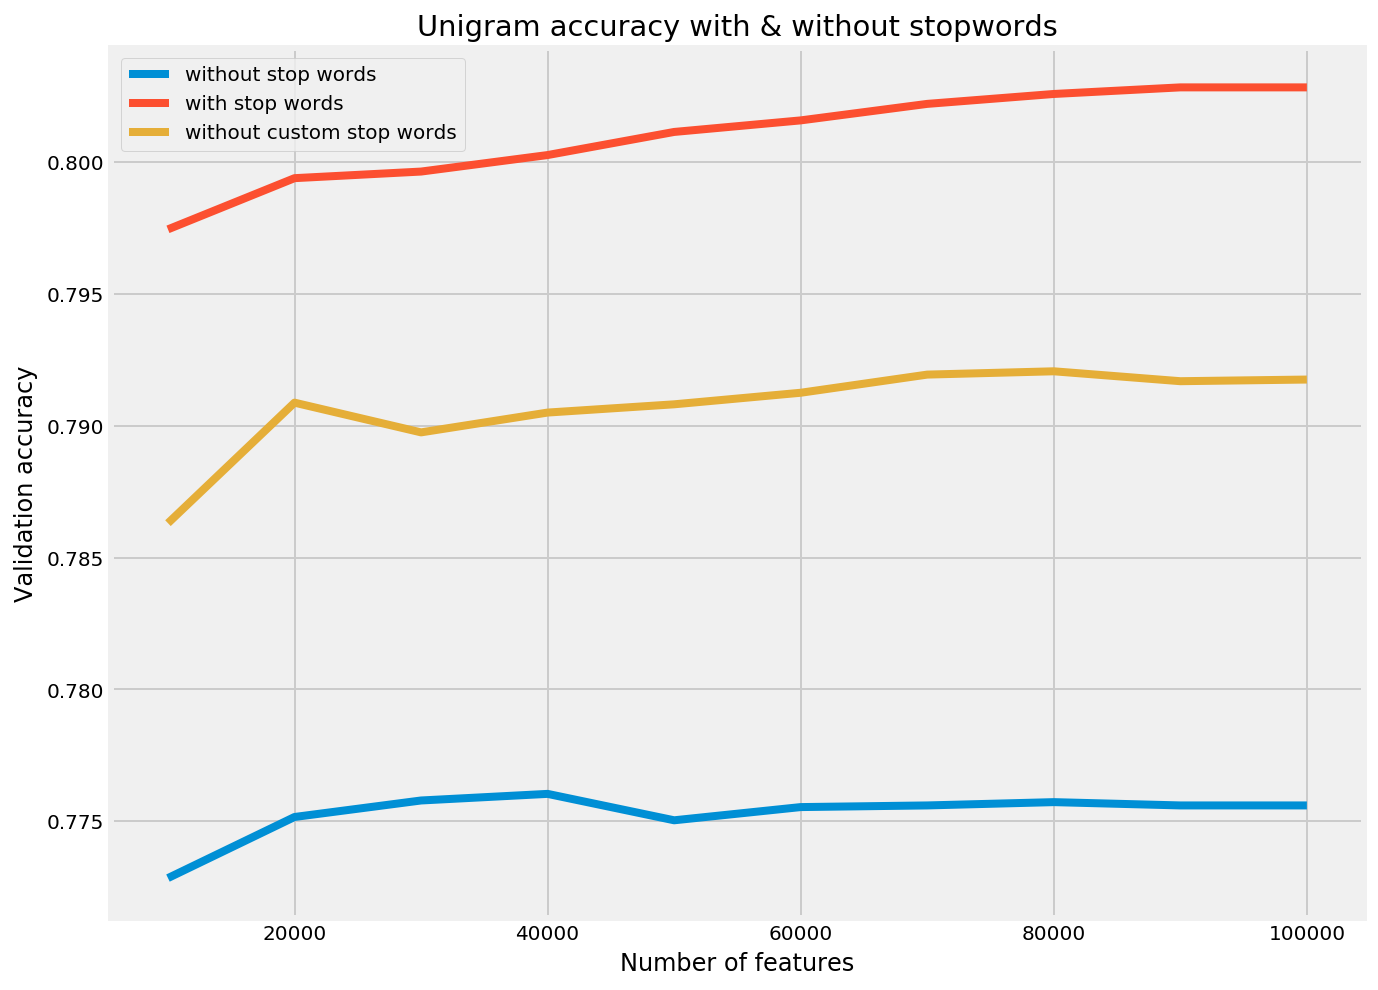

In [33]:
feature_plot_ug = pd.DataFrame(feature_result_unigram, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_wstop = pd.DataFrame(feature_result_unigram_stop, columns=['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_stopcw = pd.DataFrame(feature_result_wocw, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])
plt.figure(figsize=(10, 8))
plt.plot(feature_plot_ug.nfeatures, feature_plot_ug.validation_accuracy, label='without stop words')
plt.plot(feature_plot_wstop.nfeatures, feature_plot_wstop.validation_accuracy, label='with stop words')
plt.plot(feature_plot_stopcw.nfeatures, feature_plot_stopcw.validation_accuracy, label='without custom stop words')
plt.title('Unigram accuracy with & without stopwords')
plt.xlabel('Number of features')
plt.ylabel('Validation accuracy')
plt.legend()

In [34]:
%%time
print("RESULT FOR BIGRAM\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1,2))

RESULT FOR BIGRAM

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 

Validation result for 10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 80.62%
Model is 30.43% more accurate than null accuracy
Train and test time: 261.69s
--------------------------------------------------
Validation result for 20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 81.29%
Model is 31.10% more accurate than null accuracy
Train and test time: 264.23s
--------------------------------------------------
Validation result for 30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 81.71%
Model is 31.53% more accurate than null accuracy
Train and test time: 233.92s
--------------------------------------------------
Validation result for 40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.02%
Model is 31.83% more accurate than null accuracy
Train and test time: 283.15s
--------------------------------------------------
Validation result for 50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.04%
Model is 31.86% more accurate than null accuracy
Train and test time: 405.67s
--------------------------------------------------
Validation result for 60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.20%
Model is 32.02% more accurate than null accuracy
Train and test time: 559.82s
--------------------------------------------------
Validation result for 70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.21%
Model is 32.02% more accurate than null accuracy
Train and test time: 615.46s
--------------------------------------------------
Validation result for 80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.18%
Model is 31.99% more accurate than null accuracy
Train and test time: 491.21s
--------------------------------------------------
Validation result for 90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.19%
Model is 32.01% more accurate than null accuracy
Train and test time: 496.21s
--------------------------------------------------
Validation result for 100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.24%
Model is 32.06% more accurate than null accuracy
Train and test time: 502.90s
--------------------------------------------------
Wall time: 1h 8min 34s


In [35]:
%%time
print("RESULT FOR TRIGRAM\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1,3))

RESULT FOR TRIGRAM

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 

Validation result for 10000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 80.49%
Model is 30.31% more accurate than null accuracy
Train and test time: 404.83s
--------------------------------------------------
Validation result for 20000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 81.21%
Model is 31.03% more accurate than null accuracy
Train and test time: 427.21s
--------------------------------------------------
Validation result for 30000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 81.56%
Model is 31.38% more accurate than null accuracy
Train and test time: 395.47s
--------------------------------------------------
Validation result for 40000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 81.87%
Model is 31.68% more accurate than null accuracy
Train and test time: 571.38s
--------------------------------------------------
Validation result for 50000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.11%
Model is 31.93% more accurate than null accuracy
Train and test time: 587.49s
--------------------------------------------------
Validation result for 60000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.08%
Model is 31.89% more accurate than null accuracy
Train and test time: 648.89s
--------------------------------------------------
Validation result for 70000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.08%
Model is 31.90% more accurate than null accuracy
Train and test time: 643.72s
--------------------------------------------------
Validation result for 80000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.38%
Model is 32.19% more accurate than null accuracy
Train and test time: 643.91s
--------------------------------------------------
Validation result for 90000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.14%
Model is 31.96% more accurate than null accuracy
Train and test time: 639.40s
--------------------------------------------------
Validation result for 100000 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.25%
Model is 32.07% more accurate than null accuracy
Train and test time: 716.19s
--------------------------------------------------
Wall time: 1h 34min 39s


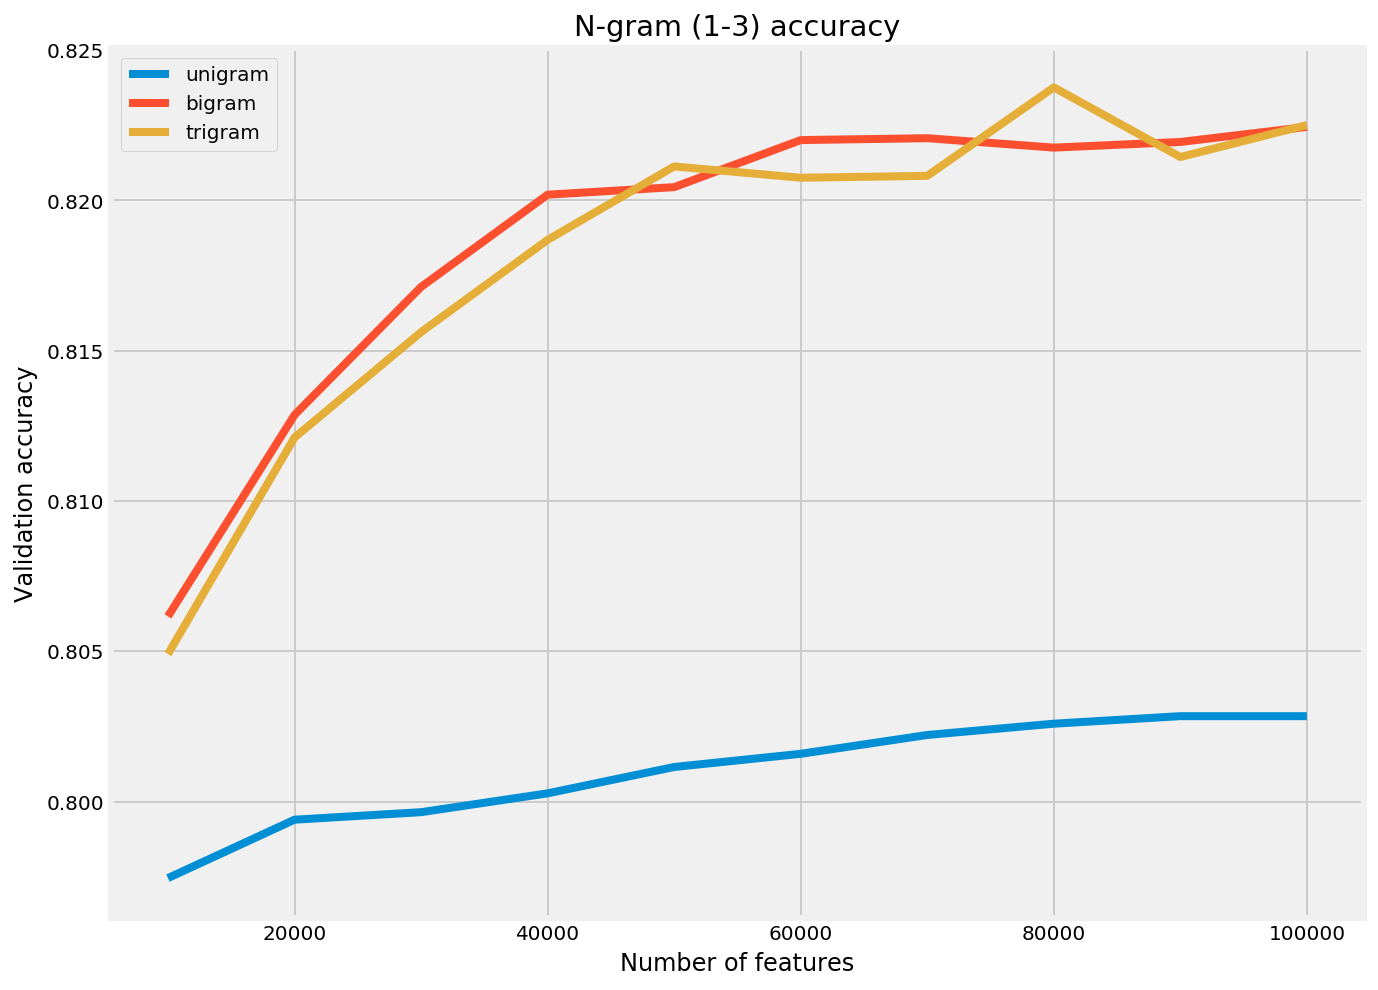

In [36]:
feature_plot_ug = pd.DataFrame(feature_result_unigram_stop, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_bg = pd.DataFrame(feature_result_bg, columns=['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_tg = pd.DataFrame(feature_result_tg, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])
plt.figure(figsize=(10, 8))
plt.plot(feature_plot_ug.nfeatures, feature_plot_ug.validation_accuracy, label='unigram')
plt.plot(feature_plot_bg.nfeatures, feature_plot_bg.validation_accuracy, label='bigram')
plt.plot(feature_plot_tg.nfeatures, feature_plot_tg.validation_accuracy, label='trigram')
plt.title('N-gram (1-3) accuracy')
plt.xlabel('Number of features')
plt.ylabel('Validation accuracy')
plt.legend()

In [37]:
null_accuracy = 0
def evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test==0])/len(x_test)>0.5:
        null_accuracy = len(x_test[y_test==0])/len(x_test)
    else:
        null_accuracy = 1 - len(x_test[y_test==0])/len(x_test)
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'], columns=['predicted_negative', 'predicted_positive'])
    print("Null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("Accuracy: {0:.2f}%".format(accuracy*100))
    if accuracy>null_accuracy:
        print("Model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy==null_accuracy:
        print("Model has the same accuracy as null accuracy")
    else:
        print("Model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("-"*50)
    print("CONFUSION MATRIX\n")
    print(confusion)
    print("-"*50)
    print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

In [38]:
%%time
ug_vector = CountVectorizer(max_features=100000)
ug_pipeline = Pipeline([('vectorizer', ug_vector), ('classifier', lr)])
evaluate(ug_pipeline, x_train, y_train, x_validation, y_validation)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 80.28%
Model is 30.10% more accurate than null accuracy
--------------------------------------------------
CONFUSION MATRIX

          predicted_negative  predicted_positive
negative                2669                5344
positive                 818                7136
--------------------------------------------------
              precision    recall  f1-score   support

    negative       0.81      0.79      0.80      8013
    positive       0.79      0.81      0.80      7954

    accuracy                           0.80     15967
   macro avg       0.80      0.80      0.80     15967
weighted avg       0.80      0.80      0.80     15967

Wall time: 4min 31s


In [39]:
%%time
bg_vector = CountVectorizer(max_features=70000, ngram_range=(1,2))
bg_pipeline = Pipeline([('vectorizer', bg_vector), ('classifier', lr)])
evaluate(bg_pipeline, x_train, y_train, x_validation, y_validation)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.21%
Model is 32.02% more accurate than null accuracy
--------------------------------------------------
CONFUSION MATRIX

          predicted_negative  predicted_positive
negative                2669                5344
positive                 818                7136
--------------------------------------------------
              precision    recall  f1-score   support

    negative       0.83      0.81      0.82      8013
    positive       0.81      0.83      0.82      7954

    accuracy                           0.82     15967
   macro avg       0.82      0.82      0.82     15967
weighted avg       0.82      0.82      0.82     15967

Wall time: 9min 46s


In [40]:
%%time
tg_vector = CountVectorizer(max_features=80000, ngram_range=(1,3))
tg_pipeline = Pipeline([('vectorizer', tg_vector), ('classifier', lr)])
evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.38%
Model is 32.19% more accurate than null accuracy
--------------------------------------------------
CONFUSION MATRIX

          predicted_negative  predicted_positive
negative                2669                5344
positive                 818                7136
--------------------------------------------------
              precision    recall  f1-score   support

    negative       0.83      0.81      0.82      8013
    positive       0.82      0.83      0.83      7954

    accuracy                           0.82     15967
   macro avg       0.82      0.82      0.82     15967
weighted avg       0.82      0.82      0.82     15967

Wall time: 10min 1s


In [41]:
feature_plot_ug.to_csv('ug-without-stopwords.csv')
feature_plot_wstop.to_csv('ug-with-stopwords.csv')
feature_plot_stopcw.to_csv('ug-without-custom-stopwords.csv')

In [43]:
feature_plot_ug.to_csv('ug.csv')
feature_plot_bg.to_csv('bg.csv')
feature_plot_tg.to_csv('tg.csv')